# Answering Business Questions using SQL
---
Now we will try and use some of the skills that we have learned during the SQL courses to answer some business questions. We will be using the famous [`chinook.db`](https://dsserver-prod-resources-1.s3.amazonaws.com/374/chinook.db) dataset as the foundation of our project.

We'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Like with our Factbook database, a schema diagram will help us understand the available columns and the structure of the data. Here's a schema diagram for the Chinook database:

![image.png](https://s3.amazonaws.com/dq-content/280/chinook-schema.svg)

### Prerequisites
#### 1. Importing the Libraries

In [1]:
# Importing the libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Plot settings
%matplotlib inline
sns.set_style('white')

#### 2. Creating Some Functions

In [2]:
# Defining the database
db = 'chinook.db'

# Defining a function to run queries
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Defining the function to run SQL commands
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

# Defining a function to show tables
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

# Previewing the tables
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Analysis
#### 1. Artist Reccomendation in US
We will try and give some recommendations for the genre which our store shoul purchase. To do this, we will find the percentage share for the genres based on our historical data. We are also presented with the choice of purchasing albums from some artists, those artists are:

|**Artist Name**|**Genre**|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

In [3]:
# Defining the query
query = '''
WITH cus_invo AS
    (
    SELECT 
        g.name genre
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country='USA'
    )
    
SELECT 
    genre,
    COUNT(genre) total_sold,
    ROUND(CAST(COUNT(genre) AS float)/(SELECT COUNT(*) FROM cus_invo),4) percentage_share
FROM cus_invo
GROUP BY 1
ORDER By 2 DESC
LIMIT 10;
'''

# Running the query
artist_rec = run_query(query)
artist_rec

,genre,total_sold,percentage_share
0,Rock,561,0.5338
1,Alternative & Punk,130,0.1237
2,Metal,124,0.1180
3,R&B/Soul,53,0.0504
4,Blues,36,0.0343
5,Alternative,35,0.0333
6,Latin,22,0.0209
7,Pop,22,0.0209
8,Hip Hop/Rap,20,0.0190
9,Jazz,14,0.0133


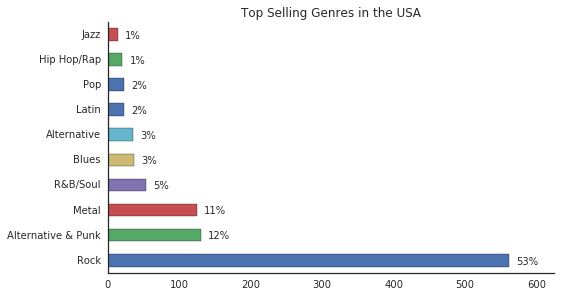

In [4]:
# Plotting the result
plt.figure(figsize = (8,4.5))
artist_rec.set_index("genre", inplace=True, drop=True)
artist_rec['total_sold'].plot.barh(title="Top Selling Genres in the USA",
    xlim=(0, 625))

# Plot settings
plt.ylabel('')
sns.despine()

# Anotating the percentage
for i, label in enumerate(list(artist_rec.index)):
    score = artist_rec.loc[label, "total_sold"]
    label = (artist_rec.loc[label, "percentage_share"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

Based on the data, we can clearly see that rock is the most selling genre by far with 561 records sold. In second is Alternative & Punk with 130 records. Thus, purchasing Red Tone's albums would be wise since the genre is the second favorite in the US.

#### 2. Sales Agent Analysis
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
# Defining the query
query = '''
WITH
    cus_inv AS
    (
    SELECT
        c.support_rep_id,
        SUM(i.total) total_purchases
    FROM customer c
    INNER JOIN invoice i ON i.customer_id=c.customer_id
    GROUP BY c.customer_id)

SELECT
    e.first_name||' '||e.last_name employee_name,
    e.hire_date,
    ROUND(SUM(ci.total_purchases),2) total_contribution
FROM employee e
INNER JOIN cus_inv ci ON ci.support_rep_id=e.employee_id
GROUP BY e.employee_id
ORDER BY 3 DESC;
'''

# Running the query
employee = run_query(query)

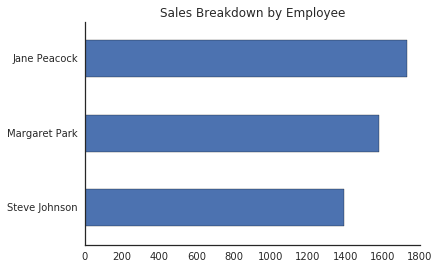

In [6]:
# Plotting the result
employee.set_index("employee_name", drop=True, inplace=True)
employee.sort_values("total_contribution", inplace=True)
employee.plot.barh(title = 'Sales Breakdown by Employee',
                  legend = False)

# Plot settings
plt.ylabel('')
sns.despine()

A quick observation tells us that Jane Peacock is the highest contributing sales agent with 1731.51 dollars and Steve Johnson is the lowest at 1393.92 dollars. There seems to be a correlation between the hire date and the total contribution where older employees tend to contribute more than newer employees.

#### 3. Sales per Country
Here we want to see where our customers are from (the country) and how much they spend in that country. This can be useful if we decide to expand to that particular country or decide to increase sales there.

In [7]:
# Defining the query
query = '''
WITH country_c AS
    (
    SELECT
        CASE
            WHEN (SELECT COUNT(*) FROM customer
                 WHERE country=c.country)=1 THEN 'Other'
            ELSE c.country
        END AS country,
        COUNT(DISTINCT c.customer_id) n_customer,
        ROUND(SUM(il.unit_price),2) total_value,
        ROUND(SUM(il.unit_price)/COUNT(DISTINCT i.invoice_id),2) average_order_Value
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id=il.invoice_id
    INNER JOIN customer c ON c.customer_id=i.customer_id
    GROUP BY 1
    )
SELECT 
    country,
    n_customer,
    total_value,
    ROUND(total_value/n_customer,2) average_value_per_customer,
    average_order_value
FROM
    (
    SELECT
        cc.*,
        CASE
            WHEN cc.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_c cc
   )
ORDER BY sort;
'''

# Running the query
country = run_query(query)
country

,country,n_customer,total_value,average_value_per_customer,average_order_Value
0,Brazil,5,427.68,85.54,7.01
1,Canada,8,535.59,66.95,7.05
2,Czech Republic,2,273.24,136.62,9.11
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,India,2,183.15,91.58,8.72
6,Portugal,2,185.13,92.56,6.38
7,USA,13,1040.49,80.04,7.94
8,United Kingdom,3,245.52,81.84,8.77
9,Other,15,1094.94,73.00,7.45


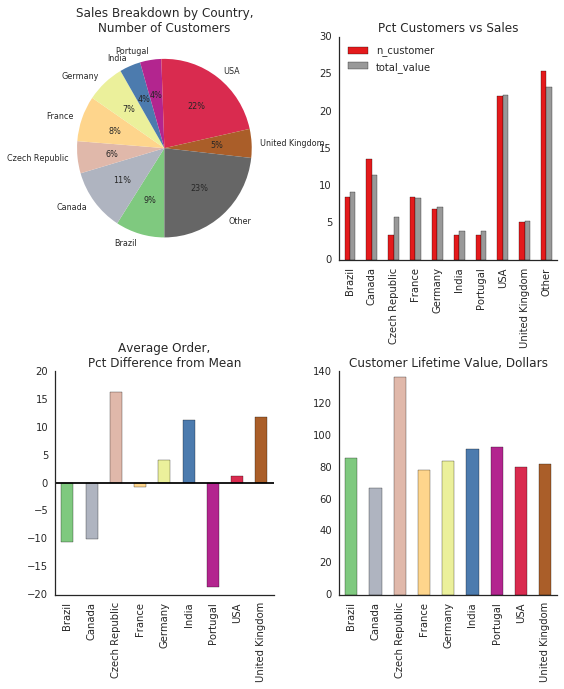

In [8]:
# Visualizing the result
country.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country["total_value"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0},
    autopct='%1.0f%%'
)

# top right
cvd_cols = ["n_customer","total_value"]
custs_vs_dollars = country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)

# bottom left
avg_order = country["average_order_Value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.axhline(0, color='k')

# bottom right
ltv = country["average_value_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
sns.despine()

plt.show()

Based on the table above, we can clearly see that there is a room for improvement for India, Czech Republic and the UK since they have the least amount of unique customers there but having the three highest average order value. That being said, we must be wary since the sample size is quite small.

#### 4. Album vs Single Tracks
The last question is whether the company should buy songs in the form of albums or tracks, we will investigate it based on the customer spending habit.

In [9]:
# Writing the query
query = '''WITH track_album AS
    (
        SELECT DISTINCT a.album_id,
                        COUNT(DISTINCT t.track_id) track_count
        FROM track t
        INNER JOIN album a ON t.album_id = a.album_id
        GROUP BY a.album_id
    ),
    
    track_il AS
    (
        SELECT il.invoice_id, 
               t.album_id,
               COUNT(DISTINCT il.track_id) track_count
        FROM track t
        INNER JOIN invoice_line il ON il.track_id = t.track_id
        GROUP BY invoice_id, album_id
    )

SELECT purchase_type,
       COUNT(DISTINCT il.invoice_id) invoice_count,
       ROUND(CAST(COUNT(DISTINCT pt.invoice_id) AS FLOAT) / (
                                                       SELECT COUNT(*) 
                                                       FROM invoice
                                                             ) * 100, 0) percentage
FROM       
   (
        SELECT il.invoice_id, 
        CASE WHEN
                til.track_count = ta.track_count THEN 'Album'
                ELSE 'Individual Tracks'
                END AS purchase_type  
        FROM invoice_line il
        INNER JOIN track_il til ON il.invoice_id = til.invoice_id
        INNER JOIN track_album ta ON til.album_id = ta.album_id
        GROUP BY il.invoice_id
   ) AS pt
INNER JOIN invoice_line il ON pt.invoice_id = il.invoice_id
GROUP BY purchase_type;
'''

# Running the query
album = run_query(query)
album

,purchase_type,invoice_count,percentage
0,Album,185,30.0
1,Individual Tracks,429,70.0


Based on the table above, it is not wise to switch into a full individual tracks business model since album sales account for almost 30 percent of Chinook's revenue.